In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
#from skimage.color import rgb2gray
#import skfuzzy as fuzz
#from ipywidgets import interact, widgets
from IPython.display import display
from PIL import Image
import pandas as pd

In [3]:
img  = Image.open("/content/gdrive/MyDrive/TP_Fuzzy_C_Means/milky-way-nvg.jpg")

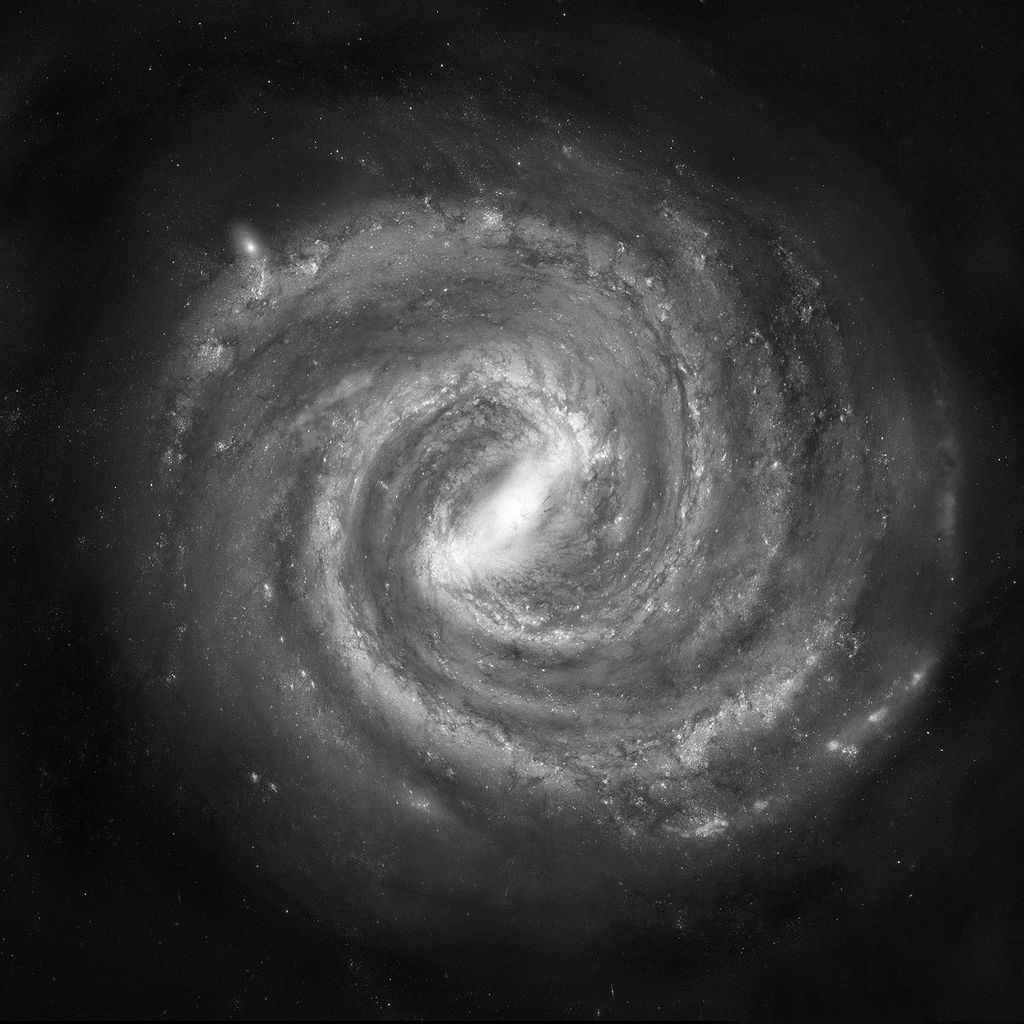

Image shape: (1024, 1024)


In [4]:
display(img)
print("Image shape:", np.array(img).shape)

In [5]:

pixels_vector = np.array(img).reshape(-1, 1)
print("Shape of the pixel vector:", pixels_vector.shape)



Shape of the pixel vector: (1048576, 1)


In [10]:
#pre-traitement
# Initialization of U matrix
# k : number of clusters

def initialize_membership_matrix(num_pixels, k):

    U = np.random.rand(num_pixels, k) + 0.001
    U = U / np.sum(U, axis=1, keepdims=True)
    return U

pixels_vector = np.array(img).reshape(-1, 1)
# pixels_vector = np.array(img).reshape(-1, 3)  # Shape: (num_pixels, 3) for RGB

#Params
k = 2
m = 1.7
error = 1e-5 #threshold de convergeance
MAX_ITERS = 500

num_pixels = pixels_vector.shape[0]
U_initial = initialize_membership_matrix(num_pixels, k)
print("Shape of the initial membership matrix U:", U_initial.shape)


Shape of the initial membership matrix U: (1048576, 2)


In [32]:
# Initioalize Centroid array

def initialize_k_values(k):
  #return np.random.randint(0, 256, size=k)
  if k == 2:
    return np.array([0, 255])



In [15]:
# Calcul des centroides (scalars)

def computeCentroids(u_matrix, centroides):

    for j in range(k):
        numerator = 0
        denominator = 0

        for i in range(pixels_vector.shape[0]):
            u_power_m = u_matrix[i, j] ** m
            numerator += u_power_m * pixels_vector[i][0]
            denominator += u_power_m

        centroides[j] = numerator / denominator

    return centroides


In [31]:
def updateWeights(u_matrix, C):
    rows, k = u_matrix.shape # num_pixels, k
    new_u_matrix = np.zeros_like(u_matrix)
    exponent = 2 / (m - 1)

    for i in range(rows): # For each pixel
        pixel_value = pixels_vector[i][0]
        distances = np.array([abs(pixel_value - C[j]) for j in range(k)])

        # Handle zero distance: if pixel_value is exactly a centroid
        # If a pixel value is exactly equal to a centroid, it gets full membership (1.0) to that cluster,
        # and 0.0 membership to all other clusters. This avoids division by zero.
        zero_distance_indices = np.where(distances < 1e-10)[0]

        if len(zero_distance_indices) > 0:

            new_u_matrix[i, zero_distance_indices] = 1.0 / len(zero_distance_indices)


        else:

            inv_distances_powered = (1.0 / distances) ** exponent

            sum_of_inv_distances_powered = np.sum(inv_distances_powered)

            new_u_matrix[i, :] = inv_distances_powered / sum_of_inv_distances_powered

    return new_u_matrix


In [26]:
#main algo

def FuzzyMeansAlgorithm(pixels_vector, k, m, max_iter=100, tolerance=1e-4):

  U = initialize_membership_matrix(pixels_vector.shape[0], k)

  C = initialize_k_values(k)

  for iteration in range(max_iter):
    U_old = U.copy()
    C = computeCentroids(U, C)
    U = updateWeights(U, C)

    diff = np.linalg.norm(U - U_old)


    if iteration % 10 == 0:
      print(f"Iteration {iteration}: difference = {diff:.6f}")

    if diff < tolerance:
      print(f"Convergence reached at iteration {iteration} with difference {diff:.6f}")
      break
  else:
    if diff >= tolerance:
      print(f"Maximum iterations reached ({max_iter}). Convergence not reached.")

  return U, C, iteration + 1

In [33]:
pixels_vector = np.array(img).reshape(-1, 1)
k = 2
m = 1.7

U_final, C_final, num_iterations = FuzzyMeansAlgorithm(pixels_vector, k, m)



Iteration 0: difference = 363.104791
Convergence reached at iteration 8 with difference 0.000000


In [40]:
import numpy as np
from PIL import Image
from IPython.display import display

def display_segmented_image_from_fuzzy(U_final, original_image_shape, C_final, threshold=0.5):

    if U_final.shape[1] != 2:
        return

    segmented_pixels = np.zeros(U_final.shape[0], dtype=np.uint8)

    segmented_pixels[U_final[:, 0] > threshold] = 255
    segmented_pixels[U_final[:, 0] <= threshold] = 0

    segmented_image_array = segmented_pixels.reshape(original_image_shape)

    display(Image.fromarray(segmented_image_array))

    print(f"Segmented image displayed using threshold: {threshold} for cluster 0 membership.")
    print(f"Centroid values used: Cluster 0 ({C_final[0]}), Cluster 1 ({C_final[1]}) \n(Note: The cluster with membership <= threshold gets assigned the second centroid's value)")


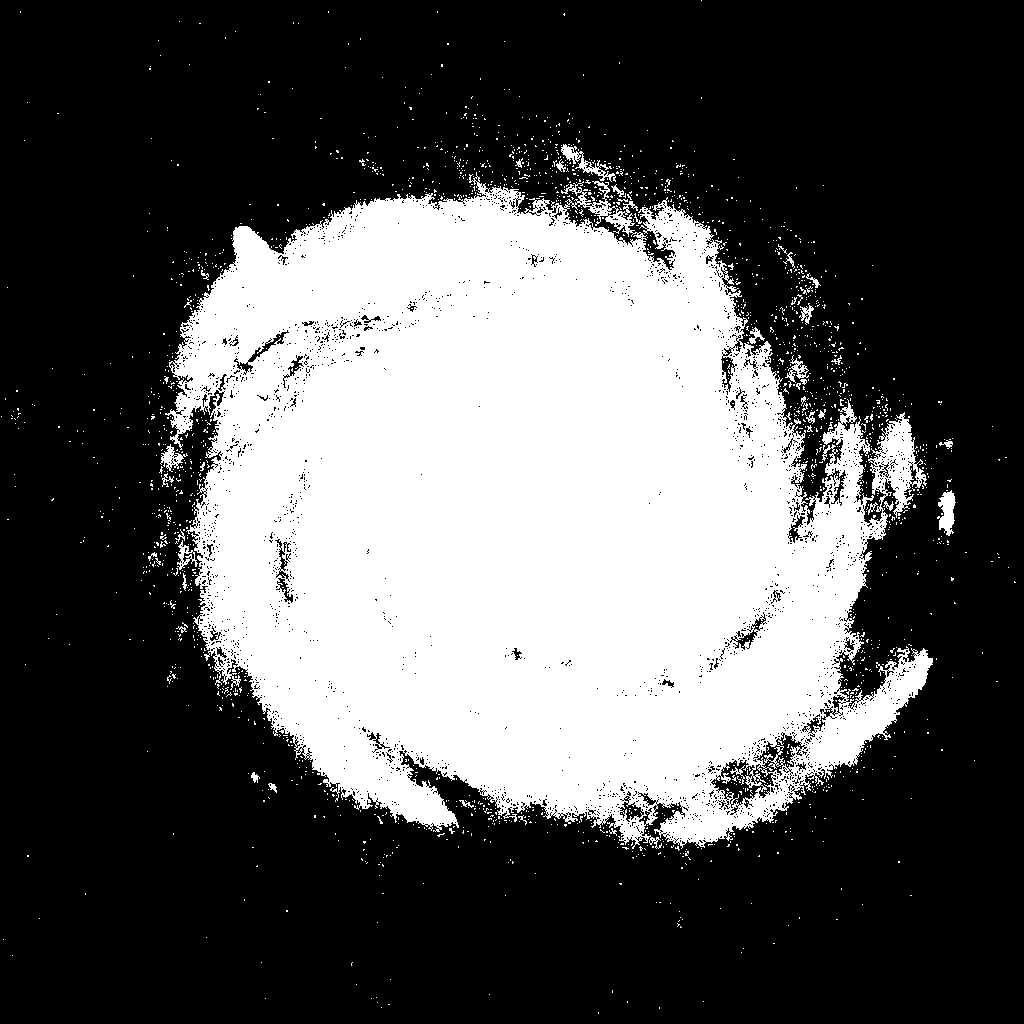

Segmented image displayed using threshold: 0.5 for cluster 0 membership.
Centroid values used: Cluster 0 (112), Cluster 1 (27) 
(Note: The cluster with membership <= threshold gets assigned the second centroid's value)


In [41]:
display_segmented_image_from_fuzzy(U_final,(1024, 1024), C_final)

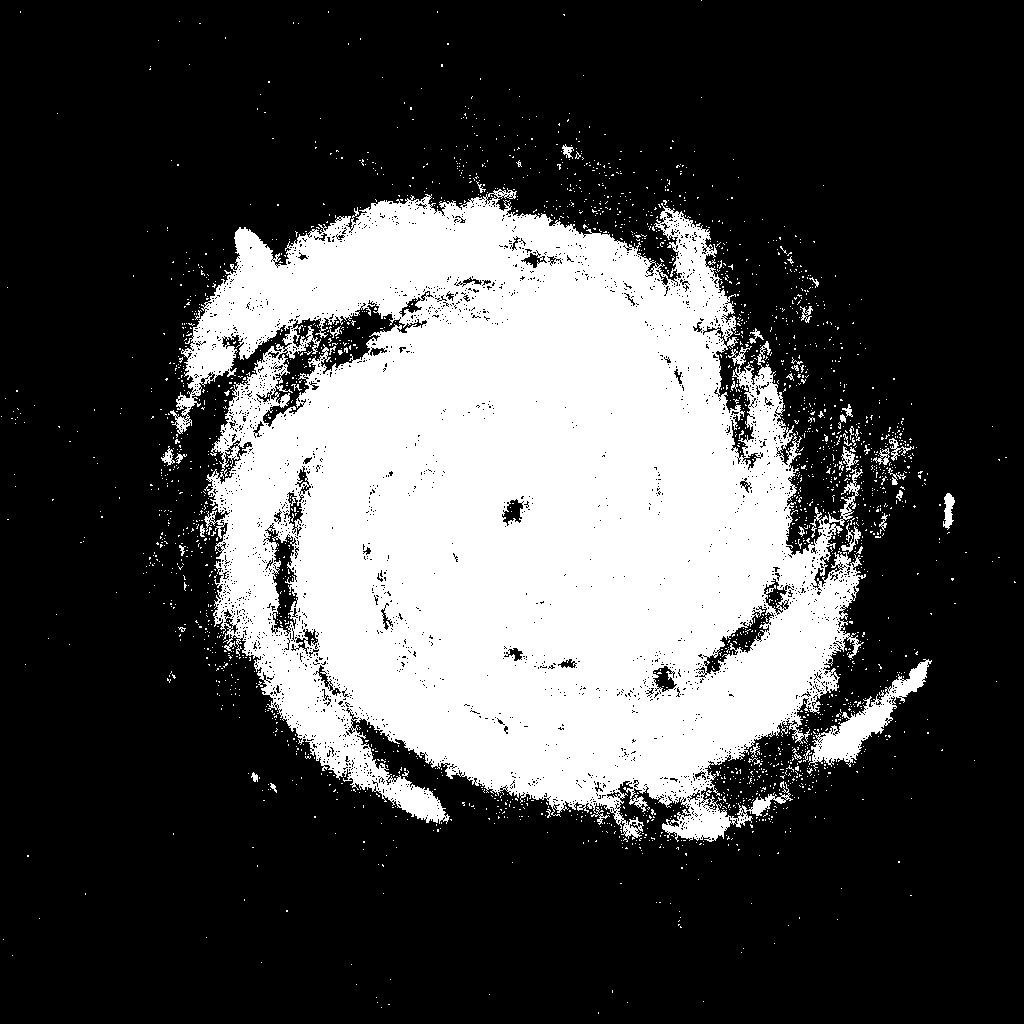

Segmented image displayed using threshold: 0.8 for cluster 0 membership.
Centroid values used: Cluster 0 (112), Cluster 1 (27) 
(Note: The cluster with membership <= threshold gets assigned the second centroid's value)


In [45]:
display_segmented_image_from_fuzzy(U_final,(1024, 1024), C_final, 0.8)

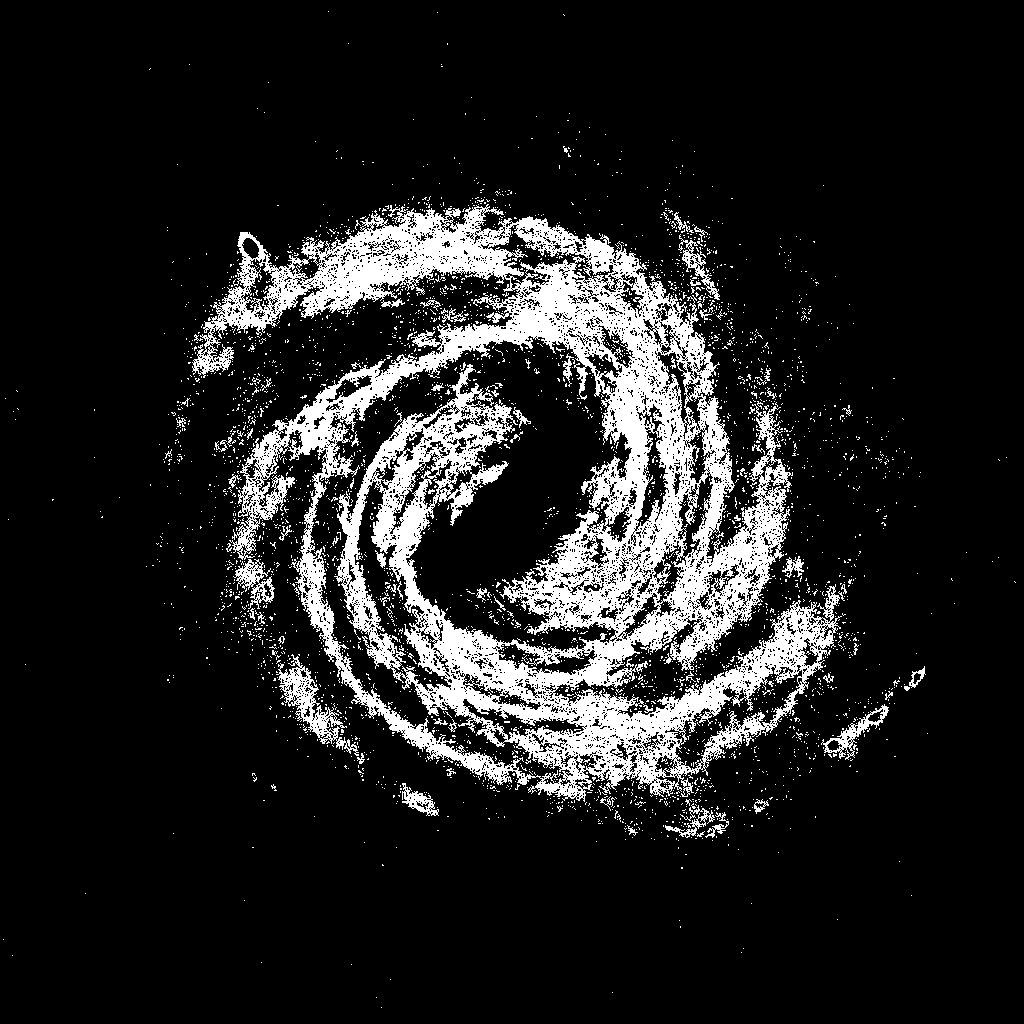

Segmented image displayed using threshold: 0.99 for cluster 0 membership.
Centroid values used: Cluster 0 (112), Cluster 1 (27) 
(Note: The cluster with membership <= threshold gets assigned the second centroid's value)


In [44]:
display_segmented_image_from_fuzzy(U_final,(1024, 1024), C_final, 0.99)

In [46]:
import matplotlib.pyplot as plt
import numpy as np

def display_fuzzy_heatmap(U_final, original_image_shape, cluster_index=0, cmap='hot'):

    if not (0 <= cluster_index < U_final.shape[1]):
        print(f"Error: cluster_index {cluster_index} is out of bounds for {U_final.shape[1]} clusters.")
        return

    membership_values = U_final[:, cluster_index]

    heatmap_array = membership_values.reshape(original_image_shape)

    plt.figure(figsize=(8, 8))
    plt.imshow(heatmap_array, cmap=cmap)
    plt.colorbar(label=f'Membership to Cluster {cluster_index}')
    plt.title(f'Fuzzy Membership Heatmap for Cluster {cluster_index}')
    plt.axis('off')
    plt.show()

    print(f"Heatmap displayed for membership to Cluster {cluster_index} using colormap '{cmap}'.")


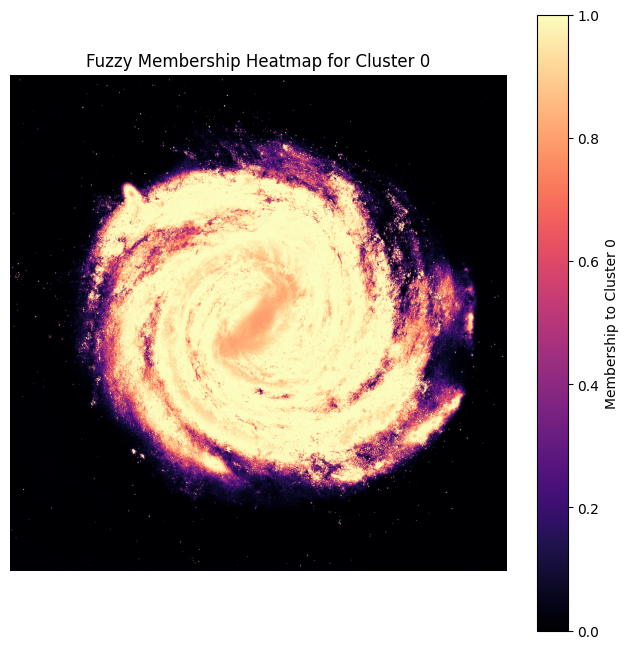

Heatmap displayed for membership to Cluster 0 using colormap 'magma'.


In [51]:
original_shape = (1024, 1024)

display_fuzzy_heatmap(U_final, original_shape, cluster_index=0, cmap='magma')
